In [1]:
import pandas as pd
import numpy as np
import glob, re, os 
import scipy.stats
from scipy.io import mmread, mmwrite
import multiprocessing as mp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import sys
display(sys.version)

'3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]'

In [2]:
import anndata
from kb_python.utils import import_matrix_as_anndata
import scanpy as sc
sc.settings.verbosity = 3

display('Scanpy:', sc.__version__)
display('Numpy:', np.__version__)
display('Pandas:', pd.__version__)

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

'Scanpy:'

'1.9.8'

'Numpy:'

'1.26.4'

'Pandas:'

'1.5.3'

# Import hDel-v4 sgRNA library

In [3]:
hdelv4 = pd.read_csv('~/Documents/hDels/hDel-v3-v4_sgRNAs/hDel-v4_sgRNA_library_sgID_FIX.tsv', sep='\t')
hdelv4['ATAC_peak_ID'].fillna('NONE', inplace=True)
hdelv4['hDel_ID'] = hdelv4['ATAC_peak_ID'].apply(lambda x: '_'.join(x.split('_')[:2]))
hdelv4

ATAC_peak_ID  start   stop  \
0    hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag  434.0  456.0   
1    hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag  435.0  457.0   
2    hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag  558.0  580.0   
3    hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag  781.0  803.0   
4                  hDel_1027_1_Omni_ATAC   20.0   42.0   
..                                   ...    ...    ...   
918                                 NONE    0.0   22.0   
919                                 NONE    0.0   22.0   
920                                 NONE    0.0   22.0   
921                                 NONE    0.0   22.0   
922                                 NONE    0.0   22.0   

                     target                             context overflow  \
0    ACCTACTGACATACGAACGGGG  CACGTGACCTACTGACATACGAACGGGGCGGCCA       OK   
1    GACCTACTGACATACGAACGGG  ACACGTGACCTACTGACATACGAACGGGGCGGCC       OK   
2    TGCGGACTAAAGTGATCTAGGG  CATCACTGCGGACTAAAGTGATCTAGGGCCCCAA       OK   
3    GCTCGCTGCAGTGGCAAGGAGG  CACACAGCTCGCTGCAGTGGCAAGGAGGTGGAGG       OK   
4    TCAGCCCAGTAGAATGCAGGGG  AGCCACTCAGCCCAGTAGAATGCAGGGGCCAGTA       OK   
..                      ...                                 ...      ...   
918                     NaN                                 NaN      NaN   
919                     NaN                                 NaN      NaN   
920                     NaN                                 NaN      NaN   
921                     NaN                                 NaN      NaN   
922                     NaN                                 NaN      NaN   

    orientation  JostCRISPRi_maxOT  JostCRISPRi_specificityscore  \
0           RVS           0.014736                      0.975842   
1           RVS           0.023058                      0.910402   
2           RVS           0.295895                      0.387609   
3           FWD           0.254058                      0.416026   
4           RVS           0.507761                      0.201676   
..          ...                ...                           ...   
918         FWD           0.225437                      0.491790   
919         FWD           0.261112                      0.471697   
920         FWD           0.375227                      0.437416   
921         FWD           0.393460                      0.412758   
922         FWD           0.407041                      0.318894   

     dangerous_GC  dangerous_polyT  dangerous_in_genome basesDiffToClosestHit  \
0        0.545455              0.0                  1.0                     2   
1        0.545455              0.0                  1.0                     2   
2        0.500000              0.0                  1.0                     3   
3        0.681818              0.0                  1.0                     2   
4        0.590909              0.0                  1.0                     2   
..            ...              ...                  ...                   ...   
918           NaN              NaN                  NaN                     3   
919           NaN              NaN                  NaN                     2   
920           NaN              NaN                  NaN                     2   
921           NaN              NaN                  NaN                     2   
922           NaN              NaN                  NaN                     3   

     closestHitCount 0-1-2-3-4_mismatch  otCount                 G_N19  \
0                1.0          1,0,1,4,0      6.0  GACCTACTGACATACGAACG   
1                1.0         1,0,1,23,0     25.0  GGACCTACTGACATACGAAC   
2               26.0         1,0,0,26,0     27.0  GTGCGGACTAAAGTGATCTA   
3                1.0         1,0,1,34,0     36.0  GGCTCGCTGCAGTGGCAAGG   
4                2.0         1,0,2,51,0     54.0  GTCAGCCCAGTAGAATGCAG   
..               ...                ...      ...                   ...   
918             27.0         0,0,0,27,0     27.0  GGAGGTTGACGTGAATGGTG   
919              1.0         0,0,1,2

# Import kallisto|bustools output for hDel-v4 sgRNA and GEX libraries

In [4]:
sgRNA_path = "/home/tyler/Documents/kallisto_bustools_kITE/hDel-v4_sgRNA_kITE_counts_filtered_concatenate.h5ad"
GEX_path = "/home/tyler/Documents/kallisto_bustools_kITE/hDel-v4_GE_counts_filtered_concatenate.h5ad"

kb_sgRNA = anndata.read_h5ad(sgRNA_path)
kb_GE = anndata.read_h5ad(GEX_path)

kb_sgRNA, kb_GE

(AnnData object with n_obs × n_vars = 19126 × 923
     obs: 'batch'
     var: 'feature_name',
 AnnData object with n_obs × n_vars = 27990 × 62260
     obs: 'batch'
     var: 'gene_name')

In [5]:
#set var_names to gene_name instead of gene_id

kb_GE.var = kb_GE.var.reset_index().astype(str).set_index('gene_name')

#make var_names unique

kb_GE.var_names_make_unique(join='_')

# Gene expression library quality control & filtering

In [6]:
#calculate QC metrics and % rDNA & mtDNA

kb_GE.var['mtRNA'] = np.array(kb_GE.var_names.str.startswith('MT-'))
kb_GE.var['rRNA'] = np.array(kb_GE.var_names.str.startswith(('RPS', 'RPL')))

sc.pp.calculate_qc_metrics(kb_GE, qc_vars=['mtRNA', 'rRNA'], percent_top=None, log1p=False, inplace=True)

In [7]:
#filter cells, use 10th percentile for genes detected and UMIs

sc.pp.filter_cells(kb_GE, min_genes=1106) 
sc.pp.filter_cells(kb_GE, min_counts=2744)

filtered out 2797 cells that have less than 1106 genes expressed
filtered out 426 cells that have less than 2744 counts


In [8]:
#filter cells >15% mtDNA or <1% mtDNA

kb_GE = kb_GE[kb_GE.obs['pct_counts_mtRNA'].between(1, 15)]
kb_GE

View of AnnData object with n_obs × n_vars = 23033 × 62260
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mtRNA', 'pct_counts_mtRNA', 'total_counts_rRNA', 'pct_counts_rRNA', 'n_genes', 'n_counts'
    var: 'gene_id', 'mtRNA', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Calculate cell-cycle scores

In [9]:
#Kowalczyk et al., Genome Res 2015

cell_cycle_genes = [x.strip() for x in open('/home/tyler/Documents/Regev_lab_cell_cycle_genes.txt')]
print('Kowalczyk:', len(cell_cycle_genes))

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [gene for gene in cell_cycle_genes if gene in kb_GE.var_names]
print('panTro6:', len(cell_cycle_genes))

Kowalczyk: 97
panTro6: 94


In [10]:
if 'Processed' in kb_GE.uns.keys():
    print('adata is already processed, skipping processing.')
else:
    
    #use layers instead of raw to store raw counts (https://github.com/scverse/anndata/issues/274)
    kb_GE.layers['raw_counts'] = kb_GE.X.copy()
    #or do both...
    kb_GE.raw = kb_GE

    #scales the gene expression values in each cell so that the total number of counts per cell is equal
    sc.pp.normalize_total(kb_GE)
    #takes the natural logarithm of the gene expression values in each cell and adds one to each value, reduce the effect of skewness by compressing the range of expression values and making the distribution more symmetrical
    sc.pp.log1p(kb_GE)
    #scales the gene expression values in each cell to have a mean of zero and a standard deviation of one across all cells, ensures that each gene expression value in each cell is transformed in the same way
    sc.pp.scale(kb_GE)
    
    #identifies highly variable genes for clustering, dimensionality reduction, and differential gene expression analysis
    sc.pp.highly_variable_genes(kb_GE, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='raw_counts')
    #computes the principal components (PCs) of the gene expression matrix, which are the linear combinations of genes that capture the most variation in the data
    sc.pp.pca(kb_GE, use_highly_variable=True)
    #calculates the pairwise distances between cells based on their gene expression profiles and constructs a graph that connects each cell to its nearest neighbors
    sc.pp.neighbors(kb_GE)

    kb_GE.uns['Processed'] = True

/tmp/ipykernel_459912/3471856166.py:6: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  kb_GE.layers['raw_counts'] = kb_GE.X.copy()


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [11]:
sc.tl.score_genes_cell_cycle(kb_GE, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    258 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    213 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


# Cluster & Visualize

In [12]:
sc.tl.leiden(kb_GE, resolution=0.1, random_state=6)
sc.tl.umap(kb_GE)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/home/tyler/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


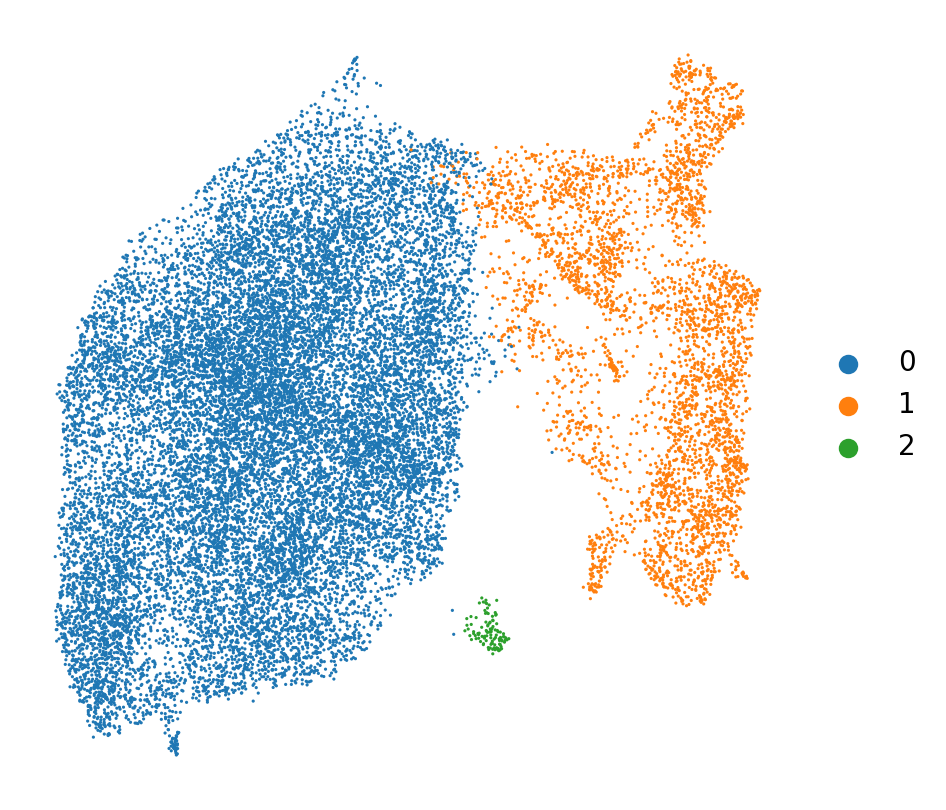

/home/tyler/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


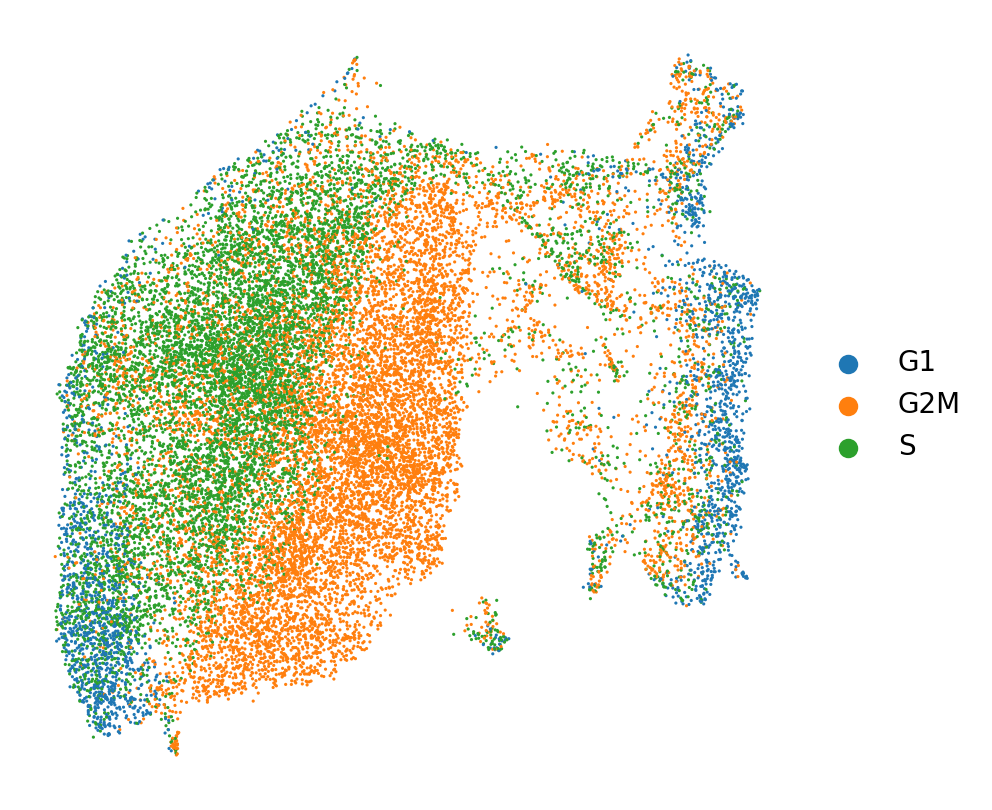

In [13]:
def plot_umap(kb_GE, color):
    fig, ax = plt.subplots(figsize=(5, 5))
    sc.pl.umap(kb_GE, color=color, ax=ax, title='', frameon=False)

plot_umap(kb_GE, color='leiden')
plot_umap(kb_GE, color='phase')

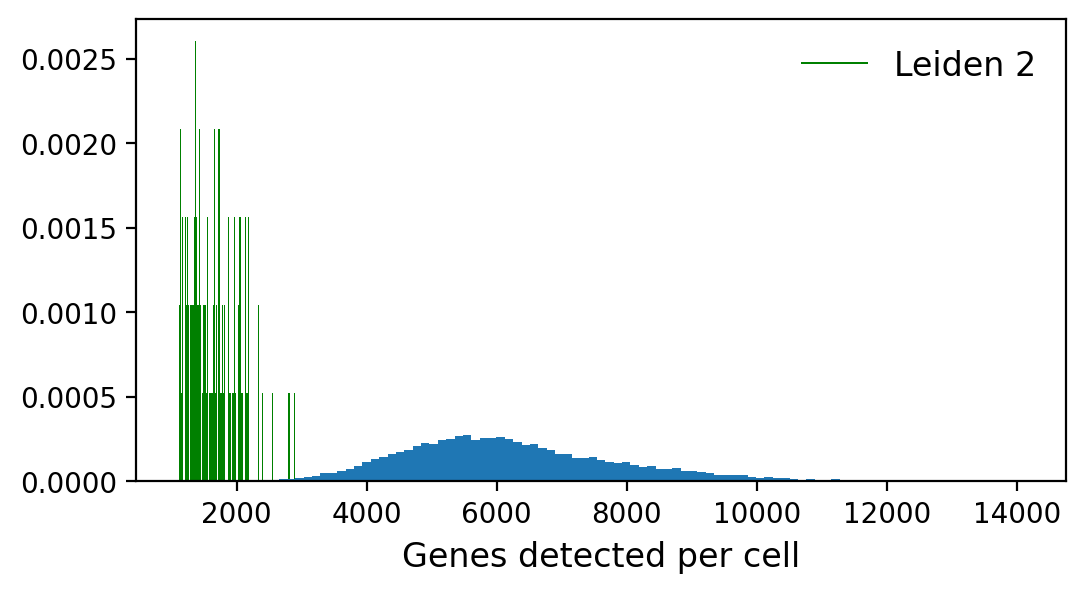

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

kb_GE.obs[kb_GE.obs['leiden'] == '2']['n_genes_by_counts'].hist(density=True, bins=100, color='green', grid=False, label='Leiden 2')
kb_GE.obs[kb_GE.obs['leiden'] != '2']['n_genes_by_counts'].hist(density=True, bins=100, grid=False, label='')

plt.xlabel('Genes detected per cell', fontsize=12)
plt.legend(frameon=False, handleheight=-0.25, fontsize=12)

plt.show()

#filter cells in Leiden 2

leiden_not2 = kb_GE.obs[kb_GE.obs['leiden'] != '2'].index
kb_GE = kb_GE[kb_GE.obs.index.isin(leiden_not2)]

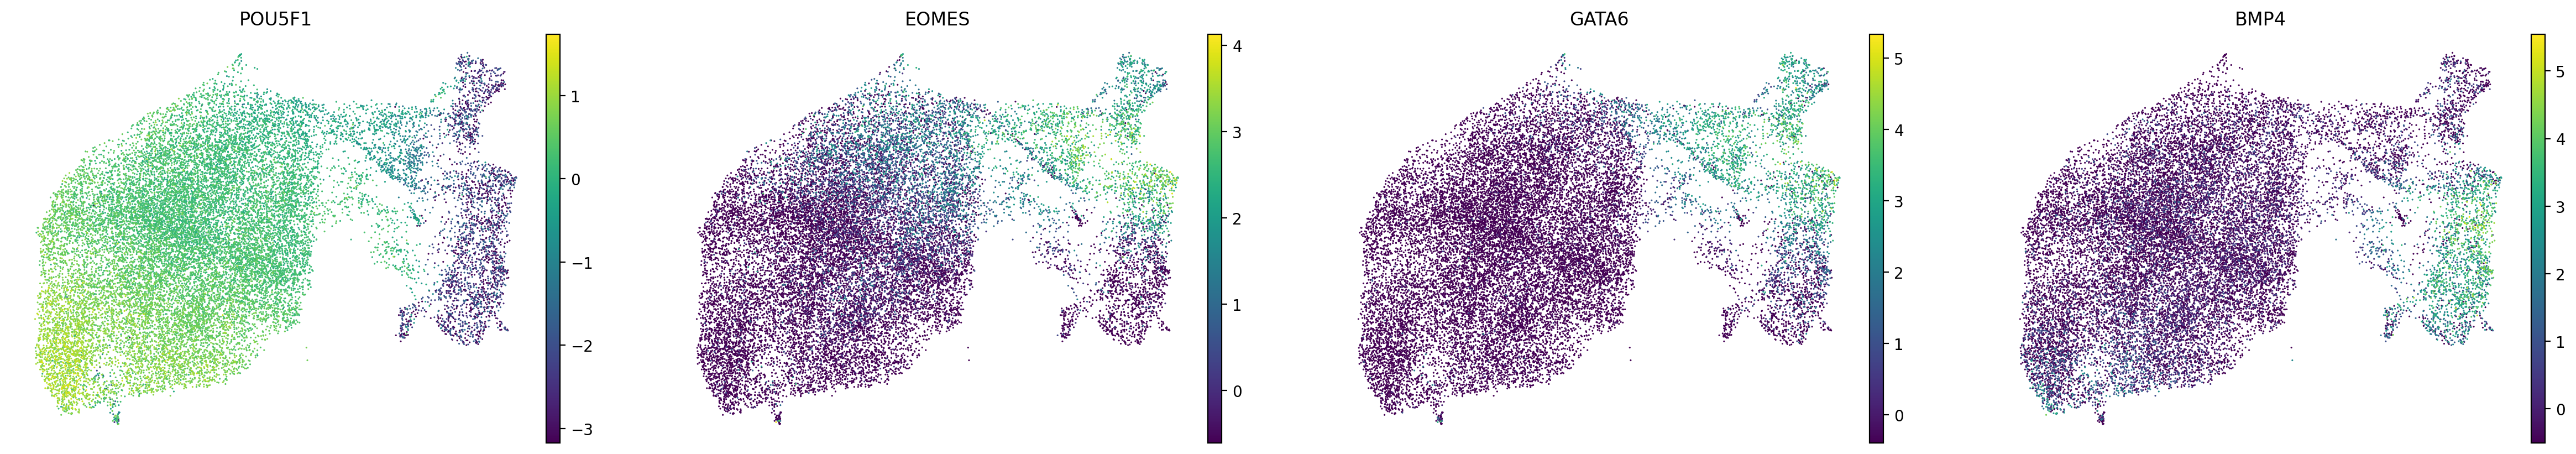

In [15]:
gene_list = ['POU5F1', 'EOMES', 'GATA6', 'BMP4']
    
sc.pl.umap(kb_GE, color=[i for i in gene_list], color_map='viridis', frameon=False, use_raw=False)

# Intersect Gene Expression and Feature Barcode sgRNA Cell Barcodes

In [16]:
shared_CBC = list(set(kb_GE.obs.index) & set(kb_sgRNA.obs.index))
len(shared_CBC)

18574

# Import Poisson-Gaussian mixture model sgRNA assignments

In [17]:
sgRNA_assignments = pd.read_csv('~/Documents/kallisto_bustools_kITE/hDelv4_PoissonGaussian_assignments.tsv', sep='\t')
sgRNA_assignments

cell_barcode                                  sg_ID    UMIs  \
0       ACAAGCTTCGAGCACC_GEM1  hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3  1718.0   
1       ACTATGGGTGAAGCGT_GEM1  hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3  1922.0   
2       ATTACCTGTAGTCGGA_GEM1  hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3  1249.0   
3       ATTGTTCAGACCAAAT_GEM1  hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3   725.0   
4       ATTGTTCCATGACTTG_GEM1  hDel_1018_1_H3K4me1_H3K27ac_CUT_Tag_3   855.0   
...                       ...                                    ...     ...   
167128  TTCTAGTAGTAGAGTT_GEM5                     ReplogleCTRL_03043   219.0   
167129  TTCTCTCCATGAGAAT_GEM5                     ReplogleCTRL_03043    91.0   
167130  TTGACCCAGTGGTGGT_GEM5                     ReplogleCTRL_03043   455.0   
167131  TTGAGTGTCGACGTCG_GEM5                     ReplogleCTRL_03043   786.0   
167132  TTGGTTTCAAGTAGTA_GEM5                     ReplogleCTRL_03043   810.0   

        PoissonGaussian  
0              0.999988  
1              0.999989  
2              0.999982  
3              0.999949  
4              0.999964  
...                 ...  
167128         0.996478  
167129         0.773831  
167130         0.999800  
167131         0.999962  
167132         0.999965  

[167133 rows x 4 columns]

In [18]:
#select shared Cell Barcodes and require >100 cells per sgRNA 

sgRNA_assignments = sgRNA_assignments.loc[sgRNA_assignments['cell_barcode'].isin(shared_CBC)].groupby('sg_ID').filter(lambda x: len(x) >= 100)

In [19]:
print('median number of UMIs per sgRNA per cell =', sgRNA_assignments['UMIs'].median())
print('median number of sgRNAs per cell =', sgRNA_assignments.groupby('cell_barcode').size().median())

median number of UMIs per sgRNA per cell = 495.0
median number of sgRNAs per cell = 7.0


In [20]:
shared_CBC = list(set(shared_CBC) & set(sgRNA_assignments['cell_barcode'].unique()))
len(shared_CBC)

18570

# Add sgRNA assignments to adata.obs

In [21]:
#select Cell Barcodes containing sgRNAs

kb_GE_filter = kb_GE[kb_GE.obs.index.isin(shared_CBC)]
kb_GE_filter

View of AnnData object with n_obs × n_vars = 18570 × 62260
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mtRNA', 'pct_counts_mtRNA', 'total_counts_rRNA', 'pct_counts_rRNA', 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_id', 'mtRNA', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'Processed', 'leiden', 'umap', 'leiden_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

In [22]:
print('median number of genes detected per cell =', kb_GE_filter.obs['n_genes_by_counts'].median())
print('median number of UMIs per cell =', kb_GE_filter.obs['total_counts'].median())

median number of genes detected per cell = 6143.0
median number of UMIs per cell = 26989.0


In [23]:
#select sgRNA Cell Barcodes with corresponding GEX Cell Barcodes

kb_sgRNA_filter = kb_sgRNA[:, kb_sgRNA.var_names.isin(sgRNA_assignments['sg_ID'].unique())][kb_sgRNA.obs.index.isin(shared_CBC)]
kb_sgRNA_filter

View of AnnData object with n_obs × n_vars = 18570 × 817
    obs: 'batch'
    var: 'feature_name'

In [24]:
#create cell by sgRNA matrix containing binary sgRNA assignments

pivot_sgRNA_assignments = sgRNA_assignments[['cell_barcode', 'sg_ID']].pivot(index='cell_barcode', columns='sg_ID', values='sg_ID').notnull().astype(int)
pivot_sgRNA_assignments

sg_ID                  Gasperini_chr1.4082_1  Gasperini_chr1.4082_2  \
cell_barcode                                                          
AAACCCAAGCCGGAAT_GEM3                      0                      0   
AAACCCAAGGGACCAT_GEM2                      0                      0   
AAACCCAAGTACGAGC_GEM1                      0                      0   
AAACCCAAGTGTTGAA_GEM3                      0                      0   
AAACCCACAAAGGTTA_GEM1                      0                      0   
...                                      ...                    ...   
TTTGTTGCAACCGTAT_GEM3                      0                      0   
TTTGTTGCAATGGGTG_GEM3                      0                      0   
TTTGTTGCAGGCATGA_GEM1                      0                      0   
TTTGTTGGTAAGATAC_GEM2                      0                      0   
TTTGTTGGTGGCATCC_GEM2                      0                      0   

sg_ID                  Gasperini_chr20.845_1  Gasperini_chr20.845_2  \
cell_barcode                                                          
AAACCCAAGCCGGAAT_GEM3                      0                      0   
AAACCCAAGGGACCAT_GEM2                      0                      0   
AAACCCAAGTACGAGC_GEM1                      0                      0   
AAACCCAAGTGTTGAA_GEM3                      0                      0   
AAACCCACAAAGGTTA_GEM1                      0                      0   
...                                      ...                    ...   
TTTGTTGCAACCGTAT_GEM3                      0                      0   
TTTGTTGCAATGGGTG_GEM3                      0                      0   
TTTGTTGCAGGCATGA_GEM1                      0                      0   
TTTGTTGGTAAGATAC_GEM2                      0                      0   
TTTGTTGGTGGCATCC_GEM2                      0                      0   

sg_ID                  Gasperini_chr7.769_1  Gasperini_chr7.769_2  \
cell_barcode                                                        
AAACCCAAGCCGGAAT_GEM3                     0                     0   
AAACCCAAGGGACCAT_GEM2                     0                     0   
AAACCCAAGTACGAGC_GEM1                     0                     0   
AAACCCAAGTGTTGAA_GEM3                     0                     0   
AAACCCACAAAGGTTA_GEM1                     0                     0   
...                                     ...                   ...   
TTTGTTGCAACCGTAT_GEM3                     0                     0   
TTTGTTGCAATGGGTG_GEM3                     0                     0   
TTTGTTGCAGGCATGA_GEM1                     0                     0   
TTTGTTGGTAAGATAC_GEM2                     0                     0   
TTTGTTGGTGGCATCC_GEM2                     0                     0   

sg_ID                  Gasperini_chr9.3633_1  Gasperini_chr9.3633_2  \
cell_barcode                                                          
AAACCCAAGCCGGAAT_GEM3                      0                      0   
AAACCCAAGGGACCAT_GEM2                      0                      0   
AAACCCAAGTACGAGC_GEM1                      0                      0   
AAACCCAAGTGTTGAA_GEM3                      0                      0   
AAACCCACAAAGGTTA_GEM1                      0                      0   
...                                      ...                    ...   
TTTGTTGCAACCGTAT_GEM3                      0                      0   
TTTGTTGCAATGGGTG_GEM3                      0                      0   
TTTGTTGCAGGCATGA_GEM1                      0                      0   
TTTGTTGGTAAGATAC_GEM2                      0                      0   
TTTGTTGGTGGCATCC_GEM2                      0                      0   

sg_ID                  Gasperini_chrX.229_1  ReplogleCTRL_00196  \
cell_barcode                                                      
AAACCCAAGCCGGAAT_GEM3                     0                   0   
AAACCCAAGGGACCAT_GEM2                     0                   0   
AAACCCAAGTACGAGC_GEM1                     0                   

In [25]:
#add sgRNA assignments to GEX

kb_GE_filter.obs = kb_GE_filter.obs.merge(pivot_sgRNA_assignments, left_index=True, right_index=True, how='left')

In [26]:
sc.pp.calculate_qc_metrics(kb_GE_filter, percent_top=None, log1p=False, inplace=True, use_raw=True)

# Filter genes prior to differential gene expession testing

In [27]:
#remove genes detected in fewer than 2000 cells (~10% of all cells)

sc.pp.filter_genes(kb_GE_filter, min_cells=2000, inplace=True)

filtered out 49891 genes that are detected in less than 2000 cells


# Pseudobulk using ADPbulk for DESeq2 differential expression testing

https://github.com/noamteyssier/adpbulk

In [28]:
from adpbulk import ADPBulk

# hDel-targeting sgRNA pseudobulk

In [ ]:
#compare (+hDel-targeting sgRNA cells) to all cells that do not contain any sgRNAs targeting the same hDel

def hDel_cell_sgRNA_selection(df, sgRNA:str):
    
    #cells containing hDel sgRNA
    specific_sgRNA_cells = set(df.loc[df['sg_ID'] == sgRNA]['cell_barcode'])
    #cells containing any sgRNA targeting the same hDel
    any_hDel_sgRNA_cells = set(df.loc[df['sg_ID'].str.contains("_".join(sgRNA.split("_")[:2]) + '_')]['cell_barcode'])
 
    return any_hDel_sgRNA_cells - specific_sgRNA_cells

def ADPBulk_hDel(sgRNA:str):
    
    #exclude cells containing other sgRNAs targeting the same hDel
    other_cells_same_hDel = hDel_cell_sgRNA_selection(sgRNA_assignments, sgRNA)
    
    #initialize the object
    adpb = ADPBulk(kb_GE_filter[~kb_GE_filter.obs.index.isin(other_cells_same_hDel)], [sgRNA, 'batch'], use_raw=True)
    #perform the pseudobulking
    pseudobulk_matrix = adpb.fit_transform()
    #retrieve sample meta data
    sample_meta = adpb.get_meta()
    
    #save counts -> must select filered genes as sc.pp.filter_genes does not remove genes from .raw slot
    pseudobulk_matrix[kb_GE_filter.var.index].to_csv('/home/tyler/Desktop/ADPBulk/{}_pseudobulk.tsv'.format(sgRNA), sep='\t', index=True)
    
    #save metadata
    sample_meta.to_csv('/home/tyler/Desktop/ADPBulk/{}_metadata.tsv'.format(sgRNA), sep='\t', index=False)

In [ ]:
for sgRNA in sgRNA_assignments.loc[sgRNA_assignments['sg_ID'].str.contains('hDel')]['sg_ID'].unique():
    ADPBulk_hDel(sgRNA)

In [ ]:
pd.Series(sgRNA_assignments.loc[sgRNA_assignments['sg_ID'].str.contains('hDel')]['sg_ID'].unique()).to_csv('/home/tyler/Desktop/hDel_v4_sgRNAs_passing_filters', index=False)

# Gasperini et al. CRE-targeting and non-targeting sgRNA pseudobulk

In [ ]:
#compare (+Gasperini CRE-targeting sgRNA cells) to all cells that do not contain any sgRNAs targeting the same CRE

def Gasperini_cell_sgRNA_selection(df, sgRNA:str):
    
    #cells containing hDel sgRNA
    specific_sgRNA_cells = set(df.loc[df['sg_ID'] == sgRNA]['cell_barcode'])
    #cells containing any sgRNA targeting the same hDel
    any_hDel_sgRNA_cells = set(df.loc[df['sg_ID'].str.contains("_".join(sgRNA.split("_")[:2]))]['cell_barcode'])
 
    return any_hDel_sgRNA_cells - specific_sgRNA_cells

def ADPBulk_other(sgRNA:str):
    
    if 'Gasperini' in sgRNA:
        #exclude cells containing other sgRNAs targeting the same Gasperini CRE
        other_cells_same_Gasperini_CRE = Gasperini_cell_sgRNA_selection(sgRNA_assignments, sgRNA)
        #initialize the object
        adpb = ADPBulk(kb_GE_filter[~kb_GE_filter.obs.index.isin(other_cells_same_Gasperini_CRE)], [sgRNA, 'batch'], use_raw=True)
    else: 
        #initialize the object
        adpb = ADPBulk(kb_GE_filter, [sgRNA, 'batch'], use_raw=True)
        
    #perform the pseudobulking
    pseudobulk_matrix = adpb.fit_transform()
    #retrieve sample meta data
    sample_meta = adpb.get_meta()
    
    #save counts, must select filered genes as sc.pp.filter_genes does not remove genes from .raw slot
    pseudobulk_matrix[kb_GE_filter.var.index].to_csv('/home/tyler/Desktop/ADPBulk/{}_pseudobulk.tsv'.format(sgRNA), sep='\t', index=True)
    
    #save metadata
    sample_meta.to_csv('/home/tyler/Desktop/ADPBulk/{}_metadata.tsv'.format(sgRNA), sep='\t', index=False)

In [ ]:
for sgRNA in sgRNA_assignments.loc[sgRNA_assignments['sg_ID'].str.contains('Replogle|Gasperini')]['sg_ID'].unique():
    ADPBulk_other(sgRNA)

In [ ]:
pd.Series(sgRNA_assignments.loc[sgRNA_assignments['sg_ID'].str.contains('Replogle|Gasperini')]['sg_ID'].unique()).to_csv('/home/tyler/Desktop/hDel_v4_Replogle_Gasperini_sgRNAs_passing_filters', index=False)

# Import hDel-v4 DESeq2 analysis

In [29]:
folder_path = "/home/tyler/Desktop/DESeq2_hDel-v4/"
file_names = glob.glob(folder_path + "*.csv")

dfs = []

for file_name in file_names:
    df = pd.read_csv(file_name)
    dfs.append(df)

DESeq2 = pd.concat(dfs, ignore_index=True)
DESeq2.rename(columns={'Unnamed: 0': 'gene_name'}, inplace=True)
DESeq2['sg_ID'].nunique()

817

In [30]:
DESeq2

gene_name     baseMean  log2FoldChange     lfcSE      stat  \
0               PI4KAP2    58.282176       -0.065666  0.337339  0.038043   
1                  HIC2   343.503866        0.112035  0.142535  0.612052   
2            AC118758.3   897.992903        0.237705  0.090878  6.738785   
3               SLC35F5    53.725106        0.068468  0.343571  0.039391   
4                 ACTR3  1311.344746       -0.082020  0.078841  1.087385   
...                 ...          ...             ...       ...       ...   
9996807           IPO11   177.007389        0.032390  0.231251  0.019491   
9996808           KIF2A  1097.561964       -0.088850  0.089369  0.993820   
9996809           DIMT1   511.712871       -0.026810  0.149790  0.031913   
9996810          SEC22B   345.466944       -0.160923  0.154410  1.098933   
9996811  Chimp_G0000777    54.237852       -0.371558  0.379804  0.991255   

           pvalue      padj                    sg_ID  
0        0.845357  0.999572  hDel_4601_2_Omni_ATAC_3  
1        0.434016  0.999572  hDel_4601_2_Omni_ATAC_3  
2        0.009434  0.632528  hDel_4601_2_Omni_ATAC_3  
3        0.842676  0.999572  hDel_4601_2_Omni_ATAC_3  
4        0.297051  0.999572  hDel_4601_2_Omni_ATAC_3  
...           ...       ...                      ...  
9996807  0.888968  0.999634   hDel_636_2_Omni_ATAC_4  
9996808  0.318810  0.999634   hDel_636_2_Omni_ATAC_4  
9996809  0.858219  0.999634   hDel_636_2_Omni_ATAC_4  
9996810  0.294500  0.999634   hDel_636_2_Omni_ATAC_4  
9996811  0.319436  0.999634   hDel_636_2_Omni_ATAC_4  

[9996812 rows x 8 columns]

In [31]:
#include standard error for Z-value calculations to reduce observed effect of low baseMean genes

DESeq2['log2FC/SE'] = DESeq2['log2FoldChange'] / DESeq2['lfcSE']

#use the product of p-value and log2 fold-change only for α-RRA rankings

DESeq2['log10pvalue_log2FoldChange'] = -abs(-np.log10(DESeq2['pvalue']) * DESeq2['log2FoldChange'])

# All genes within 100 kb of any hDel targeted with hDel-v4

In [32]:
sgRNA_window = pd.read_csv('/home/tyler/Documents/SCEPTRE/hDel-v4_sgRNAs_bedtools_window.tsv', sep='\t', header=None, 
                           names=['sgRNA_chr', 'sgRNA_start', 'sgRNA_end', 'sg_ID', 'ref_chr', 'ref_start', 'ref_end', 'gene_id', 'gene_name'])

sgRNA_window['hDel_ID'] = sgRNA_window['sg_ID'].str.split('_').str[:2].str.join('_')
sgRNA_window

sgRNA_chr  sgRNA_start  sgRNA_end  \
0     000160F_qps_76k_5345227        30307      30328   
1     000160F_qps_76k_5345227        30307      30328   
2     000160F_qps_76k_5345227        30307      30328   
3     000160F_qps_76k_5345227        30307      30328   
4     000160F_qps_76k_5345227        30308      30329   
...                       ...          ...        ...   
5659                     chrX     73154115   73154136   
5660                     chrX     73154216   73154237   
5661                     chrX     73154246   73154267   
5662                     chrX     73154249   73154270   
5663                     chrX     73154255   73154276   

                        sg_ID                  ref_chr  ref_start   ref_end  \
0     hDel_6854_1_Omni_ATAC_1  000160F_qps_76k_5345227       9506     11140   
1     hDel_6854_1_Omni_ATAC_1  000160F_qps_76k_5345227       9957     10452   
2     hDel_6854_1_Omni_ATAC_1  000160F_qps_76k_5345227      15182     22298   
3     hDel_6854_1_Omni_ATAC_1  000160F_qps_76k_5345227      48639     58255   
4     hDel_6854_1_Omni_ATAC_2  000160F_qps_76k_5345227       9506     11140   
...                       ...                      ...        ...       ...   
5659  hDel_7051_1_Omni_ATAC_1                     chrX   73035475  73320279   
5660  hDel_7051_1_Omni_ATAC_2                     chrX   73035475  73320279   
5661  hDel_7051_1_Omni_ATAC_3                     chrX   73035475  73320279   
5662  hDel_7051_1_Omni_ATAC_4                     chrX   73035475  73320279   
5663  hDel_7051_1_Omni_ATAC_5                     chrX   73035475  73320279   

             gene_id   gene_name    hDel_ID  
0     Chimp_G0000033  AL355497.1  hDel_6854  
1     Chimp_G0000034     BTF3P10  hDel_6854  
2     Chimp_G0000035      RAET1K  hDel_6854  
3     Chimp_G0000036       ULBP1  hDel_6854  
4     Chimp_G0000033  AL355497.1  hDel_6854  
...              ...         ...        ...  
5659  Chimp_G0061025        ATRX  hDel_7051  
5660  Chimp_G0061025        ATRX  hDel_7051  
5661  Chimp_G0061025        ATRX  hDel_7051  
5662  Chimp_G0061025        ATRX  hDel_7051  
5663  Chimp_G0061025        ATRX  hDel_7051  

[5664 rows x 10 columns]

In [33]:
#filter to genes detected in at least 10% of cells

sgRNA_window = sgRNA_window.loc[sgRNA_window['gene_name'].isin(DESeq2['gene_name'].unique())]
sgRNA_window['gene_name'].nunique()

276

In [34]:
#include Gasperini CRE target genes

Gasperini = ['TMSB4X', 'ID1', 'FSCN1', 'EPB41']

DESeq2_hDel_genes = DESeq2.loc[DESeq2['gene_name'].isin(sgRNA_window['gene_name'].unique()) | DESeq2['gene_name'].isin(Gasperini)]
DESeq2_hDel_genes['gene_name'].nunique()

280

# Compute Z-scores for each sgRNA for each gene

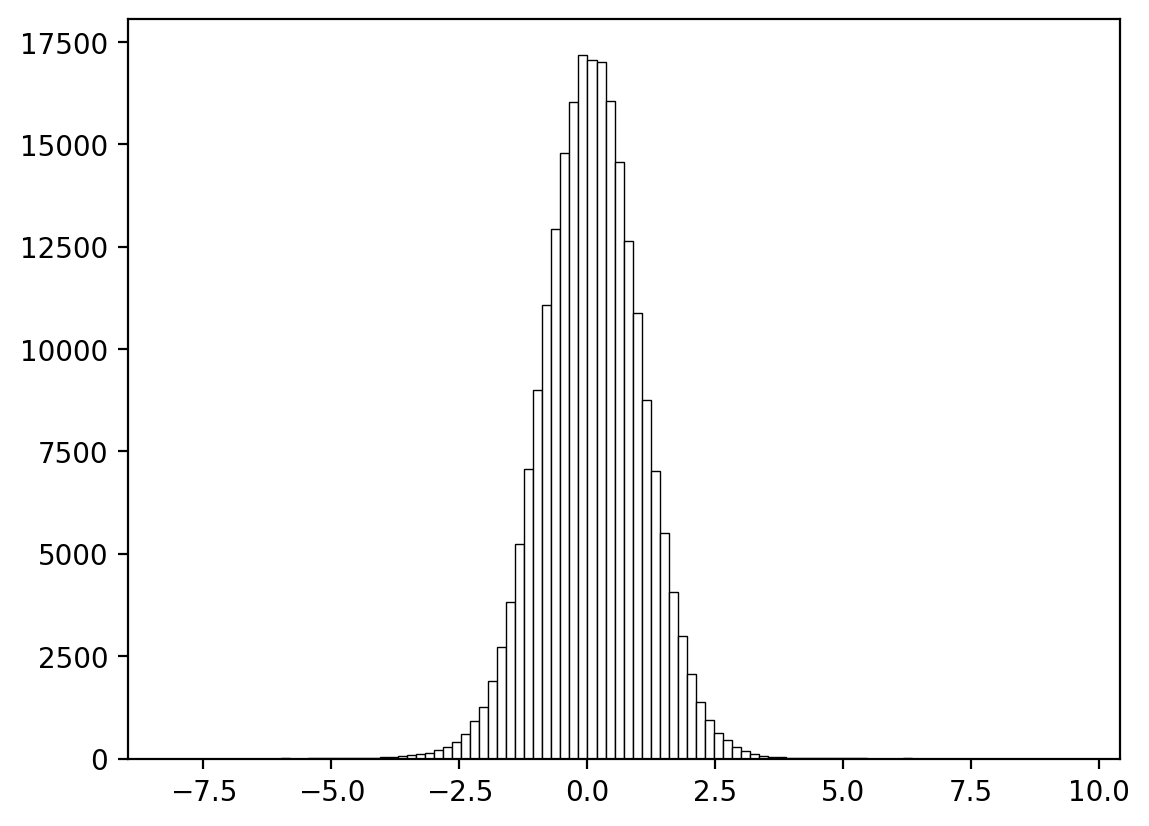

In [35]:
#log2FC/SE must be normally distributed, p-value is calculated from the survival function of a normal distribution

DESeq2_hDel_genes['log2FC/SE'].hist(bins=100, grid=False, color='white', edgecolor='black', linewidth=0.50)
plt.show()

In [36]:
#for each gene, recalculate sgRNA p-values, using sgRNAs >100 kb from the gene as null distribution

def sgRNA_gene_Z_pvalue(gene):
    
    #exclude sgRNAs < 100 kb of gene from null distribution
    sgRNAs_not_null = sgRNA_window.loc[sgRNA_window['gene_name'] == gene]['sg_ID']

    #sgRNAs for null distribution (>100 kb from the gene)
    sgRNAs_null = DESeq2.loc[(DESeq2['gene_name'] == gene) & (~DESeq2['sg_ID'].isin(sgRNAs_not_null))]['log2FC/SE']

    mean = np.mean(sgRNAs_null)
    stdev = np.std(sgRNAs_null)

    #compute Z-scores
    z_scores = []
    
    for log2FC in DESeq2.loc[DESeq2['gene_name'] == gene]['log2FC/SE']:
        z = (log2FC - mean) / stdev
        z_scores.append(z)

    #recalculate p-value using the cumulative distribution function of normal distribution (two-sided)
    new_pvalue = []
    
    for z_score in z_scores:
        p = scipy.stats.norm.sf(abs(z_score)) * 2
        new_pvalue.append(p)

    return gene, new_pvalue

In [37]:
#recalculate p-values for all sgRNA-gene pairs, use multiprocessing to accelerate

pool = mp.Pool(processes=mp.cpu_count() - 1)
results = pool.map(sgRNA_gene_Z_pvalue, DESeq2_hDel_genes['gene_name'].unique())
pool.close()
pool.join()

for gene, pvalues in results:
    DESeq2_hDel_genes.loc[DESeq2_hDel_genes['gene_name'] == gene, 'Z_pvalue'] = pvalues

In [38]:
def sgRNA_groups(row):
    if 'Gasperini' in row['sg_ID'] or 'hDel' in row['sg_ID']:
        return row['sg_ID'].split('_')[0] + '_' + row['sg_ID'].split('_')[1]
    elif 'Replogle' in row['sg_ID']:
        return 'negative_control'
    else:
        return None

DESeq2_hDel_genes['hDel_ID'] = DESeq2_hDel_genes.apply(sgRNA_groups, axis=1)

# Benjamini-Hochberg procedure for multiple hypothesis correction

In [39]:
#hDel-gene pairs within 100 Kb

hDels_genes = sgRNA_window[['gene_name', 'hDel_ID']].drop_duplicates()
hDels_genes

gene_name    hDel_ID
43     LINC00337    hDel_27
48          ICMT    hDel_27
51        KCNAB2    hDel_27
110         RERE    hDel_33
131        MFAP2    hDel_56
...          ...        ...
5639  AL118516.1  hDel_6842
5640        CERK  hDel_6842
5641      GRAMD4  hDel_6842
5642    TBC1D22A  hDel_6842
5659        ATRX  hDel_7051

[284 rows x 2 columns]

In [40]:
#select sgRNA-level hDel-gene pairs within 100 Kb

DESeq2_hDel_genes_pairs = pd.merge(DESeq2_hDel_genes, hDels_genes, on=['gene_name', 'hDel_ID'], how='inner')
DESeq2_hDel_genes_pairs

gene_name    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0         DLG2  292.388624       -0.179565  0.153302  1.394664  0.237619   
1         DLG2  355.269123        0.013142  0.127348  0.010636  0.917858   
2         DLG2  386.040011       -0.066835  0.129656  0.266428  0.605738   
3         DLG2  235.633360       -0.283872  0.188032  2.339274  0.126148   
4         DLG2  361.821723       -0.001606  0.129382  0.000154  0.990097   
...        ...         ...             ...       ...       ...       ...   
1352   FAAP100  161.204670        0.277181  0.189309  2.094083  0.147870   
1353   FAAP100  158.963310        0.288049  0.197651  2.075262  0.149704   
1354    NPLOC4  355.182444       -0.036854  0.137755  0.071821  0.788703   
1355    NPLOC4  420.252118        0.119357  0.126312  0.885304  0.346753   
1356    NPLOC4  395.616836        0.036528  0.132723  0.075544  0.783429   

          padj                    sg_ID  log2FC/SE  \
0     0.999572  hDel_4601_2_Omni_ATAC_3  -1.171312   
1     0.999124  hDel_4601_2_Omni_ATAC_5   0.103196   
2     0.997800  hDel_4601_1_Omni_ATAC_3  -0.515479   
3          NaN  hDel_4601_1_Omni_ATAC_5  -1.509703   
4     0.999863  hDel_4601_2_Omni_ATAC_4  -0.012412   
...        ...                      ...        ...   
1352       NaN  hDel_6111_1_Omni_ATAC_5   1.464168   
1353       NaN  hDel_6111_1_Omni_ATAC_1   1.457361   
1354       NaN  hDel_6111_1_Omni_ATAC_4  -0.267536   
1355       NaN  hDel_6111_1_Omni_ATAC_5   0.944943   
1356       NaN  hDel_6111_1_Omni_ATAC_1   0.275223   

      log10pvalue_log2FoldChange  Z_pvalue    hDel_ID  
0                      -0.112070  0.459710  hDel_4601  
1                      -0.000489  0.521173  hDel_4601  
2                      -0.014551  0.977053  hDel_4601  
3                      -0.255235  0.268747  hDel_4601  
4                      -0.000007  0.605656  hDel_4601  
...                          ...       ...        ...  
1352                   -0.230093  0.347873  hDel_6111  
1353                   -0.237573  0.352195  hDel_6111  
1354                   -0.003799  0.198212  hDel_6111  
1355                   -0.054902  0.821157  hDel_6111  
1356                   -0.003872  0.542192  hDel_6111  

[1357 rows x 12 columns]

In [41]:
#Benjamini-Hochberg

reject, pvals_corrected, _, _ = multipletests(DESeq2_hDel_genes_pairs['Z_pvalue'], method='fdr_bh')
DESeq2_hDel_genes_pairs['BH_pvalue'] = pvals_corrected

In [42]:
DESeq2_hDel_genes_pairs.loc[DESeq2_hDel_genes_pairs['BH_pvalue'] < 0.1].sort_values('gene_name')

gene_name     baseMean  log2FoldChange     lfcSE       stat  \
244   AC011447.7  1006.331154        0.284872  0.079125  12.736848   
1314        AGO2  1167.784582       -0.211801  0.080623   7.004398   
784         ATRX  2205.672124       -0.234513  0.060973  14.947056   
539      C4orf48  1503.846138        0.217073  0.073532   8.637392   
541      C4orf48  1256.319698        0.260029  0.073670  12.256848   
864         CERK   237.041216       -0.390854  0.181399   4.819234   
867         CERK   339.174828       -0.439208  0.129208  12.018599   
866         CERK   300.063508       -0.468266  0.148447  10.336797   
1179       DRAP1  1948.107106        0.151447  0.056553   7.112637   
1263      FAM49B  2139.422427       -0.388141  0.059877  42.483606   
1265      FAM49B  1527.362071       -0.220769  0.069554  10.215167   
35          FAT3   399.540133       -0.389199  0.136377   8.363572   
1056       GRTP1   688.901489       -0.302068  0.107908   7.960338   
1087       HADHA  1175.448713       -0.334633  0.074846  20.487034   
1085       HADHA   921.869241       -0.411723  0.100714  17.088916   
960    LINC01355    63.754345        0.805228  0.345491   5.117992   
998         PCCA   464.533625       -0.387194  0.109791  12.850923   
905        PEX13   225.751548        0.373572  0.178488   4.269368   
129        PLPP1   286.957492       -0.464068  0.153315   9.535431   
130        PLPP1   367.825819       -0.284491  0.120956   5.667188   
128        PLPP1   231.887286       -0.489614  0.190596   6.884076   
131        PLPP1   319.150735       -0.324816  0.145496   5.087793   
123        PLPP1   283.017463       -0.409713  0.155129   7.231673   
126        PLPP1   312.843675       -0.432282  0.143457   9.400659   
119        PLPP1   306.823221       -0.350859  0.150508   5.575212   
121        PLPP1   327.857390       -0.351273  0.134106   7.064658   
523      ST6GAL1   444.500490       -0.334289  0.158225   4.497792   
524      ST6GAL1   447.502223       -0.528293  0.129451  17.405187   
526      ST6GAL1   581.106116       -0.266117  0.110265   5.908107   
632       SUCLG2   827.598430       -0.516090  0.088187  35.596572   

            pvalue          padj                                  sg_ID  \
244   3.585214e-04  5.213925e-02                hDel_6391_1_Omni_ATAC_4   
1314  8.130972e-03  9.996155e-01  hDel_3813_1_H3K4me1_H3K27ac_CUT_Tag_3   
784   1.105704e-04  2.312765e-02                hDel_7051_1_Omni_ATAC_3   
539   3.293325e-03  1.626186e-01                hDel_1608_1_Omni_ATAC_5   
541   4.635539e-04  4.894027e-01                hDel_1608_1_Omni_ATAC_1   
864   2.814385e-02  9.999726e-01                hDel_6842_1_Omni_ATAC_5   
867   5.267229e-04  1.645664e-01                hDel_6842_1_Omni_ATAC_3   
866   1.304041e-03  9.998940e-01                hDel_6842_1_Omni_ATAC_2   
1179  7.654242e-03  9.978100e-01                hDel_4544_1_Omni_ATAC_4   
1263  7.127715e-11  6.523285e-07                hDel_3779_1_Omni_ATAC_3   
1265  1.392904e-03           NaN                hDel_3779_1_Omni_ATAC_5   
35    3.828173e-03           NaN  hDel_4623_1_H3K4me1_H3K27ac_CUT_Tag_5   
1056  4.781348e-03  4.296742e-02                hDel_5288_1_Omni_ATAC_3   
1087  6.003658e-06  1.705789e-03                 hDel_585_1_Omni_ATAC_4   
1085  3.566988e-05  1.454855e-01                 hDel_585_1_Omni_ATAC_3   
960   2.367900e-02  9.996539e-01                  hDel_76_1_Omni_ATAC_3   
998   3.373127e-04           NaN                hDel_5262_1_Omni_ATAC_2   
905   3.880536e-02  9.996446e-01                 hDel_698_1_Omni_ATAC_2   
129   2.015429e-03  2.619505e-01                hDel_2247_3_Omni_ATAC_2   
130   1.728514e-02           NaN                hDel_2247_2_Omni_ATAC_3   
128   8.696699e-03           NaN                hDel_2247_1_Omni_ATAC_1   
131   2.409484e-02           NaN                hDel_2247_1_Omni_ATAC_5   
123   7.162843e-03           NaN                hDel_2247_1_Omni_ATAC_4   
126   2.169074e-03  9.863798e-01    